# Модель предсказания вероятности лива пользователя

Импорты библиотек и данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sklearn.linear_model as lin
import sklearn.preprocessing as pre
import sklearn.pipeline as pipe
import sklearn.naive_bayes as nb
import sklearn.model_selection as sel
import sklearn.ensemble as ens
import sklearn.discriminant_analysis as disc
import sklearn.metrics as metr
from sklearn.base import BaseEstimator
from typing import Iterable, Callable
from itertools import product

train_file = "train.csv"
test_file = "test.csv"

import os
for dirname, _, _ in os.walk("/kaggle/input"):
    train_path = os.path.join(dirname, train_file)
    test_path = os.path.join(dirname, test_file)
    
    if os.path.exists(train_path):
        train = pd.read_csv(train_path)
        
    if os.path.exists(test_path):
        test = pd.read_csv(test_path)

Вывод названий колонок

In [2]:
cols = train.columns
cols

Index(['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'Sex',
       'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService',
       'HasMultiplePhoneNumbers', 'HasInternetService',
       'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection',
       'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription',
       'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod', 'Churn'],
      dtype='object')

**Моделирование вероятности лива по периоду оказания услуг**

Гистограмма по периоду оказания услуг

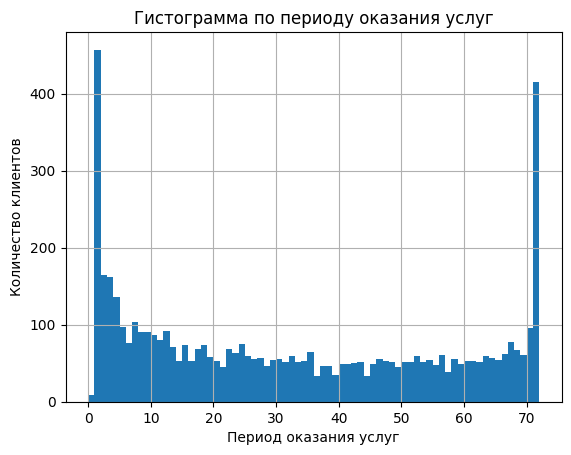

In [3]:
client_per_int = train['ClientPeriod'].max() - train['ClientPeriod'].min()
period_hist = train.hist(column='ClientPeriod', bins=client_per_int)[0][0]

period_hist.set_title("Гистограмма по периоду оказания услуг")
period_hist.set_xlabel("Период оказания услуг")
period_hist.set_ylabel("Количество клиентов")

plt.show()

Гистограма по периоду оказания услуг, дифферецированная на ливнувших и оставшихся пользователей

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

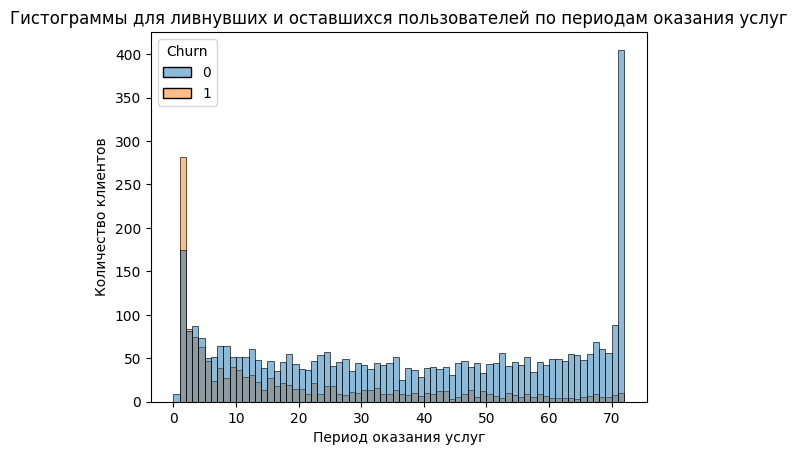

In [4]:
periods_hist_churn = sns.histplot(data=train, x='ClientPeriod', hue='Churn', bins=client_per_int)
periods_hist_churn.set_title("Гистограммы для ливнувших и оставшихся пользователей по периодам оказания услуг")
periods_hist_churn.set_xlabel("Период оказания услуг")
periods_hist_churn.set_ylabel("Количество клиентов")

plt.show()

На гистограмме заметна обратная корреляция числа ливнувших пользователей от периода оказания услуг. Поскольку величина периода оказания услуг дискретна, то можно оценить долю ливнувших пользователей от общего числа пользователей для каждого периода

Диаграмма доли ливнувших пользователей по периодам оказания услуг

In [5]:
def get_ratios(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    nonzero_periods = train[train['ClientPeriod'] > 0]

    clients_by_periods = nonzero_periods.groupby('ClientPeriod')\
        .size()\
        .to_numpy()

    churns_by_periods = nonzero_periods[nonzero_periods['Churn'] == 1].groupby('ClientPeriod')\
        .size()\
        .to_numpy()

    ratio = churns_by_periods / clients_by_periods
    periods = np.arange(client_per_int) + 1
    
    return periods, ratio

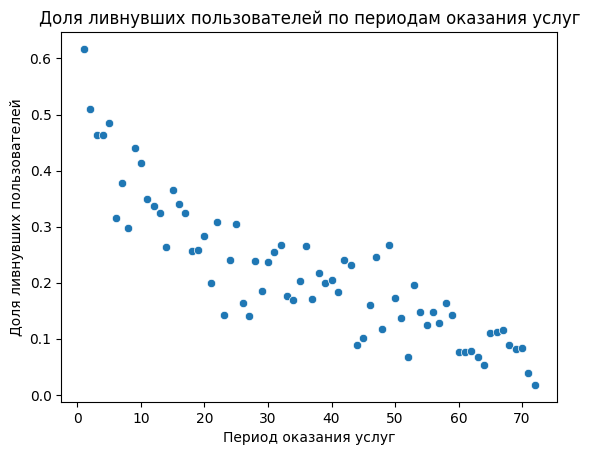

In [6]:
periods, ratio = get_ratios(train)

ratio_plot = sns.scatterplot(x=periods, y=ratio)
ratio_plot.set_title("Доля ливнувших пользователей по периодам оказания услуг")
ratio_plot.set_xlabel("Период оказания услуг")
ratio_plot.set_ylabel("Доля ливнувших пользователей")

plt.show()

Проверка ранговой корреляции доли ливнувших пользователей от периода оказания услуг

In [7]:
ratio_period_corr = stats.spearmanr(periods, ratio).correlation
print("Ранговая корреляция доли ливнувших пользователей и периода оказания услуг: {0:.2f}".format(ratio_period_corr))

Ранговая корреляция доли ливнувших пользователей и периода оказания услуг: -0.89


Величина ранговой корреляции доли ливнувших пользователей и периода оказания услуг очень высокая, следовательно можно обучить регрессию для определения вероятности лива от периода оказания услуг

Обучение линейной и некоторых линеаризуемых нелинейнейных регрессий

In [8]:
RatioPersReg = tuple[Callable[[np.ndarray], np.ndarray], float]

def ratio_pers_reg(df: pd.DataFrame, trans_x=lambda x: x, \
                   trans_y=lambda y: y, rtrans_y=lambda y: y) -> RatioPersReg:
    def get_train_test(df_train_i: Iterable[int], df_test_i: Iterable[int]) \
                      -> tuple[pd.DataFrame, pd.DataFrame]:
        df_train = df.iloc[df_train_i]
        df_test = df.iloc[df_test_i]
        
        return df_train, df_test

    def get_pers_X_ratio_t(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
        pers, ratio = get_ratios(df)
        pers_t, ratio_t = trans_x(pers), trans_y(ratio)
        
        pers_t_X = np.reshape(pers_t, (-1, 1))
        
        return pers_t_X, ratio_t
    
    def get_ridge(pers_t_X: np.ndarray, ratio_t: np.ndarray, alp: float) -> lin.Ridge:
        reg = lin.Ridge(alpha=a)
        reg.fit(pers_t_X, ratio_t)
        
        return reg

    alphas = [0.005, 0.05, 0.1, 0.5, 1, 2, 5, 10]
    
    cv = sel.RepeatedKFold(n_splits=3, n_repeats=20)
    
    final_reg = None
    final_r2 = 0
    for a in alphas:
        part_r2s = []
        
        for df_train_i, df_test_i in cv.split(df):
            df_train, df_test = get_train_test(df_train_i, df_test_i)

            pers_train_t_X, ratio_train_t = get_pers_X_ratio_t(df_train)
            pers_test_t_X, ratio_test_t = get_pers_X_ratio_t(df_test)

            part_reg = get_ridge(pers_train_t_X, ratio_train_t, a)
            
            r2 = part_reg.score(pers_test_t_X, ratio_test_t)
            part_r2s.append(r2)
            
        pers_t_X, ratio_t = get_pers_X_ratio_t(df)
        
        reg = get_ridge(pers_t_X, ratio_t, a)
        
        r2 = np.mean(part_r2s)
        
        if r2 > final_r2:
            final_reg = reg
            final_r2 = r2
            
    def predictor(pers):
        pers_t = trans_x(pers)
        
        pers_t_X = np.reshape(pers_t, (-1, 1))
        
        ratio_pred = final_reg.predict(pers_t_X)
        ratio_pred_t = rtrans_y(ratio_pred)
        
        return ratio_pred_t
    
    return predictor, final_r2

In [9]:
def ratio_pers_l(df: pd.DataFrame) -> RatioPersReg:
    pred, r2 = ratio_pers_reg(df)
    
    return pred, r2

ratio_lreg, ratio_pers_lrscore = ratio_pers_l(train)
print("R2 score линейной модели: {0:.2f}".format(ratio_pers_lrscore))

R2 score линейной модели: 0.76


In [10]:
def ratio_pers_e(df: pd.DataFrame) -> RatioPersReg:
    pred, r2 = ratio_pers_reg(df, trans_y=np.log, rtrans_y=np.exp)
    
    return pred, r2

ratio_ereg, ratio_pers_erscore = ratio_pers_e(train)
print("R2 score экспоненциальной модели: {0:.2f}".format(ratio_pers_erscore))

R2 score экспоненциальной модели: 0.74


In [11]:
def ratio_pers_lg(df: pd.DataFrame) -> RatioPersReg:
    pred, r2 = ratio_pers_reg(df, trans_x=np.log)
    
    return pred, r2

ratio_lgreg, ratio_pers_lgrscore = ratio_pers_lg(train)
print("R2 score логарифмической модели: {0:.2f}".format(ratio_pers_lgrscore))

R2 score логарифмической модели: 0.84


In [12]:
def ratio_pers_h(df: pd.DataFrame) -> RatioPersReg:
    pred, r2 = ratio_pers_reg(df, trans_x=lambda x: 1 / x)
    
    return pred, r2

ratio_hreg, ratio_pers_hrscore = ratio_pers_h(train)
print("R2 score гиперболической модели: {0:.2f}".format(ratio_pers_hrscore))

R2 score гиперболической модели: 0.49


In [13]:
def ratio_pers_lgi(df: pd.DataFrame) -> RatioPersReg:
    pred, r2 = ratio_pers_reg(df, 
        trans_y=lambda y: np.log((1 - y) / y), \
        rtrans_y=lambda y: 1 / (1 + np.exp(y))
    )
    
    return pred, r2

ratio_lgireg, ratio_pers_lgirscore = ratio_pers_lgi(train)
print("R2 score логистической модели: {0:.2f}".format(ratio_pers_lgirscore))

R2 score логистической модели: 0.76


In [14]:
periods_X = np.reshape(periods, (-1, 1))

sp_knots = [2, 3, 4]
sp_deg = [1, 2, 3, 4]
sp_alpha = [0.005, 0.05, 0.1, 0.5, 1, 5, 10]

ratio_pers_spreg = None
ratio_pers_sprscore = 0
for knot, deg, alp in product(sp_knots, sp_deg, sp_alpha):
    reg = pipe.make_pipeline(pre.SplineTransformer(n_knots=knot, degree=3), lin.Ridge(alpha=alp))
    
    reg.fit(periods_X, ratio)
    r2 = reg.score(periods_X, ratio)
    
    if r2 > ratio_pers_sprscore:
        ratio_pers_sprscore = r2
        ratio_pers_spreg = reg
        
def ratio_spreg(periods):
    periods_X = np.reshape(periods, (-1, 1))
    
    ratio = ratio_pers_spreg.predict(periods_X)
    return ratio
        
print("R2 score сплайна: {0:.2f}".format(ratio_pers_sprscore))

R2 score сплайна: 0.85


Визуализация регрессионных моделей доли ливнувших пользователей от периода оказания услуг

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

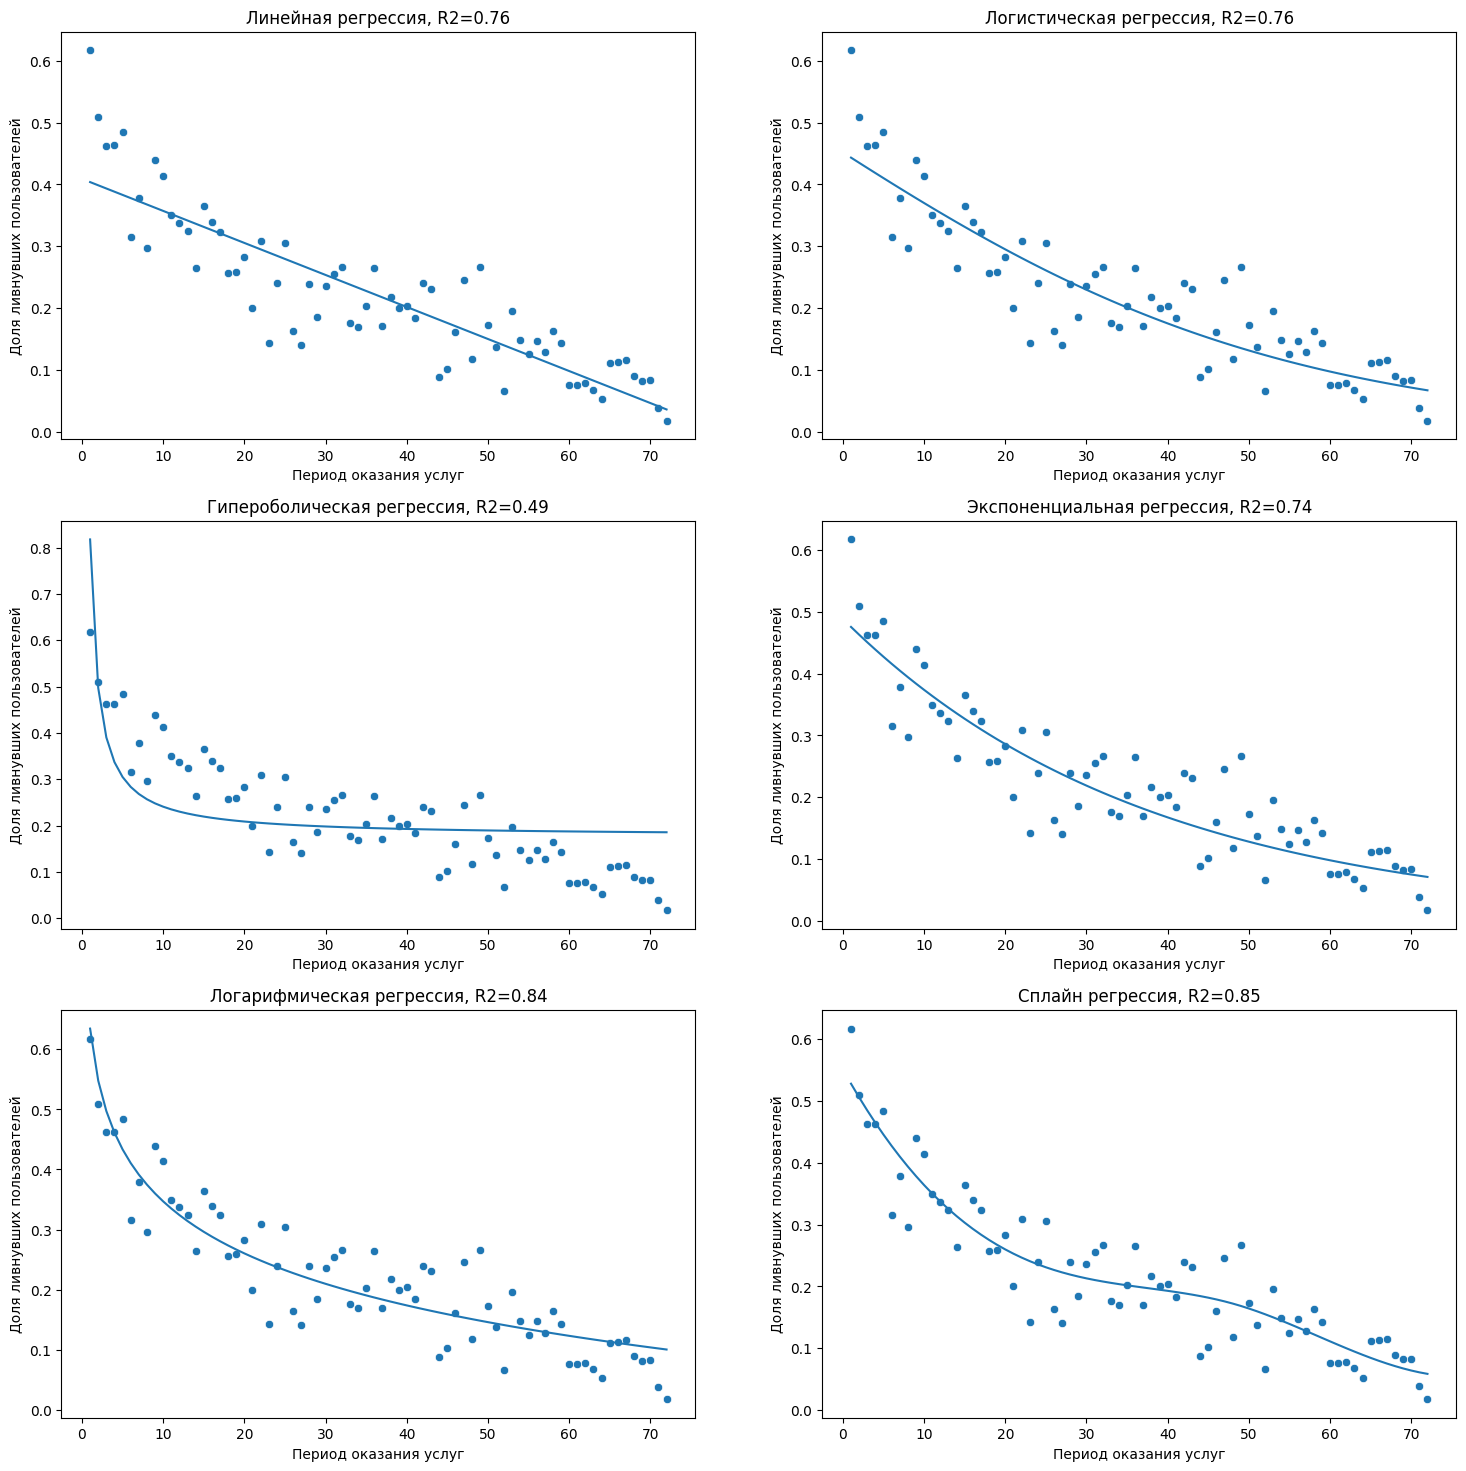

In [15]:
fig, ax = plt.subplots(3, 2, figsize=(18, 18))

titles = [
    "Линейная регрессия, R2={0:.2f}".format(ratio_pers_lrscore),
    "Логистическая регрессия, R2={0:.2f}".format(ratio_pers_lgirscore),
    "Гипероболическая регрессия, R2={0:.2f}".format(ratio_pers_hrscore),
    "Экспоненциальная регрессия, R2={0:.2f}".format(ratio_pers_erscore),
    "Логарифмическая регрессия, R2={0:.2f}".format(ratio_pers_lgrscore),
    "Сплайн регрессия, R2={0:.2f}".format(ratio_pers_sprscore),
]

for a, tit in zip(ax.flatten(), titles):
    sns.scatterplot(x=periods, y=ratio, ax=a)
    
    a.set_title(tit)
    a.set_xlabel("Период оказания услуг")
    a.set_ylabel("Доля ливнувших пользователей") 

ratio_pred_l = ratio_lreg(periods_X)
ratio_pers_llin = sns.lineplot(x=periods, y=ratio_pred_l, ax=ax[0, 0])

ratio_pred_lgi = ratio_lgireg(periods_X)
ratio_pers_lgilin = sns.lineplot(x=periods, y=ratio_pred_lgi, ax=ax[0, 1])

ratio_pred_h = ratio_hreg(periods_X)
ratio_pers_hlin = sns.lineplot(x=periods, y=ratio_pred_h, ax=ax[1, 0])

ratio_pred_e = ratio_ereg(periods_X)
ratio_pers_elin = sns.lineplot(x=periods, y=ratio_pred_e, ax=ax[1, 1])

ratio_pred_lg = ratio_lgreg(periods_X)
ratio_pers_lglin = sns.lineplot(x=periods, y=ratio_pred_lg, ax=ax[2, 0])

ratio_pred_sp = ratio_spreg(periods_X)
ratio_pers_splin = sns.lineplot(x=periods, y=ratio_pred_sp, ax=ax[2, 1])

plt.show()

Оценка log loss для полученных регрессий вероятности лива от периода оказания услуг

In [16]:
def ratio_lgloss(df: pd.DataFrame, ratio_reg: Callable[[np.ndarray], np.ndarray]) -> float:
    nonzero_period = df[df['ClientPeriod'] > 0]

    nzp_churn = nonzero_period['Churn']
    nzp_churn_pred = nonzero_period['ClientPeriod'] \
        .map(ratio_reg) \
        .to_numpy()

    lgloss = metr.log_loss(nzp_churn, nzp_churn_pred)
    return lgloss

ratio_l_lgloss = ratio_lgloss(train, ratio_lreg)
print("log loss линейной регрессии вероятности от периода оказания услуг {0:.3f}".format(ratio_l_lgloss))

ratio_lgi_lgloss = ratio_lgloss(train, ratio_lgireg)
print("log loss логистической регрессии вероятности от периода оказания услуг {0:.3f}".format(ratio_lgi_lgloss))

ratio_h_lgloss = ratio_lgloss(train, ratio_hreg)
print("log loss гиперболической регрессии вероятности от периода оказания услуг {0:.3f}".format(ratio_h_lgloss))

ratio_e_lgloss = ratio_lgloss(train, ratio_ereg)
print("log loss экспоненциальной регрессии вероятности от периода оказания услуг {0:.3f}".format(ratio_e_lgloss))

ratio_lg_lgloss = ratio_lgloss(train, ratio_lgreg)
print("log loss логарифмической регрессии вероятности от периода оказания услуг {0:.3f}".format(ratio_lg_lgloss))

ratio_sp_lgloss = ratio_lgloss(train, ratio_spreg)
print("log loss сплайновой регрессии вероятности от периода оказания услуг {0:.3f}".format(ratio_sp_lgloss))

log loss линейной регрессии вероятности от периода оказания услуг 0.512
log loss логистической регрессии вероятности от периода оказания услуг 0.509
log loss гиперболической регрессии вероятности от периода оказания услуг 0.534
log loss экспоненциальной регрессии вероятности от периода оказания услуг 0.507
log loss логарифмической регрессии вероятности от периода оказания услуг 0.505
log loss сплайновой регрессии вероятности от периода оказания услуг 0.504


В дальнейшим для оценки вероятности лива по периоду оказания услуг будем использовать логарифмическую регрессию, поскольку она обладает наименьшим log loss среди простейших линеаризуемых моделей, а сплайновая регрессия, являясь более сложной моделью, не дает значительного увеличения log loss, но обладает большей тенденцией к overfit-у.

Оценка ROC AUC для регрессии вероятности лива от периода оказания услуг

In [17]:
def ratio_auc(df: pd.DataFrame, ratio_reg: Callable[[np.ndarray], np.ndarray]) -> float:
    nonzero_period = df[df['ClientPeriod'] > 0]

    nzp_churn = nonzero_period['Churn']
    nzp_churn_pred = nonzero_period['ClientPeriod'] \
        .map(ratio_reg) \
        .to_numpy()

    lgloss = metr.roc_auc_score(nzp_churn, nzp_churn_pred)
    return lgloss

ratio_lg_auc = ratio_auc(train, ratio_lgreg)
print("ROC AUC регрессии вероятности от периода оказания услуг {0:.3f}".format(ratio_lg_auc))

ROC AUC регрессии вероятности от периода оказания услуг 0.741


**Моделирование вероятности лива от среднемесячного расхода**

Гистограмма среднемесячных расходов ливнувших и не ливнувших пользователей

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


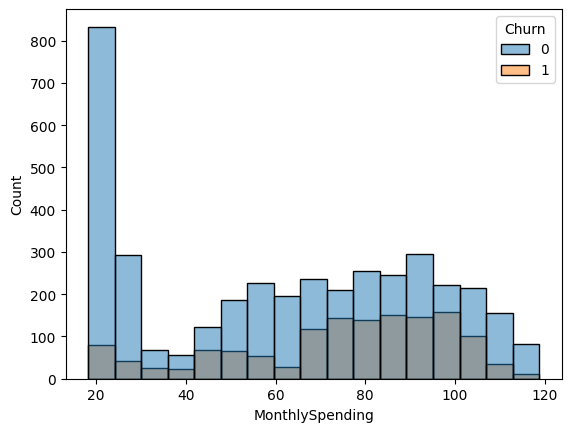

In [18]:
mspeed_hist = sns.histplot(data=train, x='MonthlySpending', hue='Churn')

plt.show()

Поскольку распределение ливнувших пользователей по среднемесяным расходам не дискретно, то для оценки вероятности лива будем использовать классификаторы. На гистограмме также можно видеть, что распределение ливнувших пользователей по среднемесячному расходу имеет сложный вид, следовательно будем использовать нелинейные классификаторы.

Обучение классификаторов и оценка их log loss и ROC AUC

Для ансаблей выведем также оптимальное количество эстиматоров

In [19]:
def mspend_class_scores(df: pd.DataFrame, est: BaseEstimator) -> tuple[float, float]:
    mspend = train['MonthlySpending'].to_numpy()
    mspend_X = np.reshape(mspend, (-1, 1))

    churn = train['Churn'].to_numpy()

    kfold = sel.KFold(n_splits=10)

    lglosses = sel.cross_val_score(
        est, mspend_X, churn, cv=kfold, scoring='neg_log_loss'
    )
    lgloss = np.mean(np.abs(lglosses))

    aucs = sel.cross_val_score(
        est, mspend_X, churn, cv=kfold, scoring='roc_auc'
    )
    auc = np.mean(aucs)
    
    return lgloss, auc

def ens_chooser(df: pd.DataFrame, est_type: type, scorer) -> tuple[BaseEstimator, float, float, int]:
    n_ests = [2, 3, 5, 8, 10, 15, 20, 30, 50]
    min_leafs = [10, 15, 20, 30, 50]
    depths = [2, 3, 4, 5]
    
    est_final = None
    lgloss_final = np.inf
    auc_final = 0.5
    est_n_final = 0
    for n_est, min_leaf, depth in product(n_ests, min_leafs, depths):
        est = est_type(n_estimators=n_est, min_samples_leaf=min_leaf, max_depth=depth)
        
        lgloss, auc = scorer(df, est)
        
        if auc > auc_final:
            est_final = est
            lgloss_final = lgloss
            auc_final = auc
            est_n_final = n_est
        
    return est_final, lgloss_final, auc_final, est_n_final


mspend_p_nb = nb.GaussianNB()

# mspend_p_nblgloss, mspend_p_nblgauc = mspend_class_scores(train, mspend_p_nb)
# print("Наивный Байес от сренемесячного расхода: log loss={0:.3f}, AUC={1:.3f}".format(mspend_p_nblgloss, mspend_p_nblgauc))

# mspend_p_rf, mspend_p_rflgloss, mspend_p_rflgauc, mspend_p_rfest =\
#    ens_chooser(train, ens.RandomForestClassifier, mspend_class_scores)
# print("Рандомный лес от сренемесячного расхода: log loss={0:.3f}, AUC={1:.3f} ({2} эстиматоров)"\
#      .format(mspend_p_rflgloss, mspend_p_rflgauc, mspend_p_rfest))

mspend_p_gb, mspend_p_gblgloss, mspend_p_gblgauc, mspend_p_gbest =\
    ens_chooser(train, ens.GradientBoostingClassifier, mspend_class_scores)
print("Градиентный бустинг от сренемесячного расхода: log loss={0:.3f}, AUC={1:.3f} ({2} эстиматоров)"\
      .format(mspend_p_gblgloss, mspend_p_gblgauc, mspend_p_gbest))

Градиентный бустинг от сренемесячного расхода: log loss=0.535, AUC=0.681 (50 эстиматоров)


Далее для оценки вероятности лива по среднемесячного расхода будем использовать градиентный бустинг, поскольку по сравнению с рандомным лесом оптимальное количество эстиматоров в нем стабильно, а log loss и AUC рандомного леса и градиентного бустинга отличается незначительно.

Визуализация модели вероятности лива от среднемесячного расхода

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


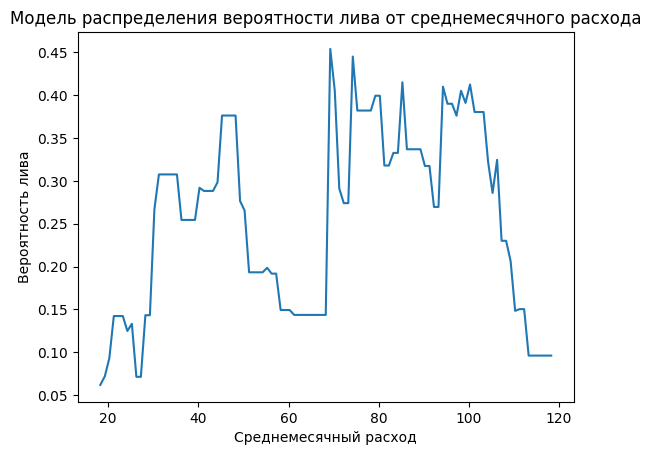

In [20]:
mspend = train['MonthlySpending']
mspend_X = np.reshape(mspend.to_numpy(), (-1, 1))

churn = train['Churn']

mspend_min = mspend.min()
mspend_max = mspend.max()
mspend_ticks = np.arange(mspend_min, mspend_max)
mspend_ticks_X = np.reshape(mspend_ticks, (-1, 1))

mspend_p_gb.fit(mspend_X, churn)
mspend_ps = mspend_p_gb.predict_proba(mspend_ticks_X)
mspend_p = mspend_ps[:, 1].transpose()

mspend_p_graph = sns.lineplot(x=mspend_ticks, y=mspend_p)
mspend_p_graph.set_title("Модель распределения вероятности лива от среднемесячного расхода")
mspend_p_graph.set_xlabel("Среднемесячный расход")
mspend_p_graph.set_ylabel("Вероятность лива")

plt.show()

**Моделирование вероятности лива от бинарных и категориальных характеристик датасета**

Расчет таблиц сопряженности для бинарных и категориальных характеристик

In [21]:
group_char_cols = ['Sex',
       'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService',
       'HasMultiplePhoneNumbers', 'HasInternetService',
       'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection',
       'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription',
       'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod']

def encode_lbl(df: pd.DataFrame, col: str) -> (np.ndarray, pre.LabelEncoder):
    enc = pre.LabelEncoder()
    
    enc_X = df[col].to_numpy().reshape(-1, 1)
    col_enc = enc.fit_transform(enc_X)
    
    return col_enc, enc

def conf_matrix(churn: Iterable[int], col_enc: Iterable[int]) -> np.ndarray:
    conf_m = metr.confusion_matrix(churn, col_enc)
    conf_m_cl = conf_m[:2,:]
    
    return conf_m_cl

def label_conf_matrix(conf_m: np.ndarray, enc: pre.LabelEncoder) -> dict:
    conf_ml = {}
    for conf_mc_i in range(conf_m.shape[1]):
        conf_mc = tuple(conf_m[:, conf_mc_i].transpose())
        
        label = enc.inverse_transform([conf_mc_i])[0]
        
        conf_ml[label] = conf_mc
        
    return conf_ml

train_groups = train[group_char_cols]

conf_ms = {}
conf_mls = {}
for col in group_char_cols:
    col_enc, enc = encode_lbl(train_groups, col)
    
    conf_m = conf_matrix(train['Churn'], col_enc)
    conf_ms[col] = conf_m
    
    conf_ml = label_conf_matrix(conf_m, enc)
    conf_mls[col] = conf_ml
    
conf_mls

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

{'Sex': {'Female': (1929, 698), 'Male': (1969, 686)},
 'IsSeniorCitizen': {0: (3410, 1030), 1: (488, 354)},
 'HasPartner': {'No': (1824, 881), 'Yes': (2074, 503)},
 'HasChild': {'No': (2538, 1138), 'Yes': (1360, 246)},
 'HasPhoneService': {'No': (392, 129), 'Yes': (3506, 1255)},
 'HasMultiplePhoneNumbers': {'No': (1891, 620),
  'No phone service': (392, 129),
  'Yes': (1615, 635)},
 'HasInternetService': {'DSL': (1458, 342),
  'Fiber optic': (1381, 960),
  'No': (1059, 82)},
 'HasOnlineSecurityService': {'No': (1518, 1094),
  'No internet service': (1059, 82),
  'Yes': (1321, 208)},
 'HasOnlineBackup': {'No': (1407, 925),
  'No internet service': (1059, 82),
  'Yes': (1432, 377)},
 'HasDeviceProtection': {'No': (1417, 900),
  'No internet service': (1059, 82),
  'Yes': (1422, 402)},
 'HasTechSupportAccess': {'No': (1530, 1074),
  'No internet service': (1059, 82),
  'Yes': (1309, 228)},
 'HasOnlineTV': {'No': (1399, 700),
  'No internet service': (1059, 82),
  'Yes': (1440, 602)},
 'Ha

Поскольку выборка достаточно большая, то мы можем применить к полученным таблицам сопряженности критерий согласия Пирсона

In [22]:
col_pvals = {}
for col, conf_m in conf_ms.items():
    x2_cont = stats.chi2_contingency(conf_m)
    
    col_pval = x2_cont.pvalue
    col_pvals[col] = col_pval
    
col_pvals

{'Sex': 0.5661255394927714,
 'IsSeniorCitizen': 6.745956242923248e-30,
 'HasPartner': 5.9150430666764906e-27,
 'HasChild': 1.9866534733080703e-32,
 'HasPhoneService': 0.46173681534370814,
 'HasMultiplePhoneNumbers': 0.015982204267404418,
 'HasInternetService': 3.5800183642948692e-115,
 'HasOnlineSecurityService': 1.9277532559286793e-146,
 'HasOnlineBackup': 2.2877886906476973e-100,
 'HasDeviceProtection': 3.471351613535349e-92,
 'HasTechSupportAccess': 1.576266752960001e-135,
 'HasOnlineTV': 1.4564312480227643e-61,
 'HasMovieSubscription': 1.3012505398296113e-62,
 'HasContractPhone': 3.576816377400634e-192,
 'IsBillingPaperless': 5.771204783785924e-45,
 'PaymentMethod': 5.39866765841293e-102}

Выбираем бинарные и категориальные признаки, укладывающиеся в доверительный интервал (p-value которых меньше confidence)

In [23]:
confidence = 1e-2

def get_significant_cols(col_pvals: dict, confidence: float) -> list[str]:
    signf_cols = list(map(
        lambda col: col[0], \
        filter(
            lambda col: col[1] < confidence, \
            col_pvals.items()
        )
    ))
    
    return signf_cols

signf_cols = get_significant_cols(col_pvals, confidence)
signf_cols

['IsSeniorCitizen',
 'HasPartner',
 'HasChild',
 'HasInternetService',
 'HasOnlineSecurityService',
 'HasOnlineBackup',
 'HasDeviceProtection',
 'HasTechSupportAccess',
 'HasOnlineTV',
 'HasMovieSubscription',
 'HasContractPhone',
 'IsBillingPaperless',
 'PaymentMethod']

В качестве модели определения вероятности лива на основе значений бинарных и категориальных признаков будем использовать линейные классификаторы. Выберем модель классификатора путем измерения их метрик.

In [24]:
train_g_signf = train_groups[signf_cols]

def encode_df_onehot(df: pd.DataFrame) -> tuple[np.ndarray, pre.OneHotEncoder]:
    df_m = df.to_numpy()
    
    enc = pre.OneHotEncoder(drop="if_binary")
    df_enc = enc.fit_transform(df_m).toarray()
    
    return df_enc, enc

def cat_clasf_score(clasf: BaseEstimator, df_enc: np.ndarray,\
                    churn: Iterable[int], scoring: str, **clasf_params) -> float:    
    kf = sel.RepeatedKFold(n_splits=3, n_repeats=10)
    scores = sel.cross_val_score(
        clasf, df_enc, churn, cv=kf, scoring=scoring
    )
    
    score = np.mean(scores)
    
    return score
    
train_g_enc, encs = encode_df_onehot(train_g_signf)

g_lgr = lin.LogisticRegression()
lgloss_lgr = cat_clasf_score(g_lgr, train_g_enc, train['Churn'], 'neg_log_loss')
auc_lgr = cat_clasf_score(g_lgr, train_g_enc, train['Churn'], 'roc_auc')
print('Log loss логистической регрессии {0:.3f}, AUC {1:.3f}'.format(abs(lgloss_lgr), auc_lgr))

g_lda = disc.LinearDiscriminantAnalysis()
lgloss_lda = cat_clasf_score(g_lda, train_g_enc, train['Churn'], 'neg_log_loss')
auc_lda = cat_clasf_score(g_lda, train_g_enc, train['Churn'], 'roc_auc')
print('Log loss LDA {0:.3f}, AUC {1:.3f}'.format(abs(lgloss_lda), auc_lda))

Log loss логистической регрессии 0.432, AUC 0.829
Log loss LDA 0.437, AUC 0.826


Логистическая регрессия показала более низкий log loss и более высокое значение AUC, следовательно в качестве модели определения вероятности лива по бинарным и категориальным признакам будем использовать логистическую регрессию

In [25]:
g_lgr = lin.LogisticRegression()
g_lgr.fit(train_g_enc, train['Churn'])

LogisticRegression()

**Моделирование итоговой вероятности лива**

Итоговую вероятность лива будем определять с помощью объединяющего классификатора, который определяет ее на основе значений вероятностей, полученных моделями выше: моделью вычисления вероятности лива по периоду оказания услуг, моделью вычисления вероятности лива по среднемесячному расходу и моделью вычисления вероятности лива по значениям бинарных и категориальных признаков.

Выбор объединяющей модели, оценивающей итоговую вероятность лива путем измерения их метрик

In [26]:
def period_proba_pred(df: pd.DataFrame) -> np.ndarray:
    probas = df['ClientPeriod']\
        .apply(lambda per: ratio_lgreg([per])[0] if per > 0 else 0)\
        .to_numpy()
    
    return probas

def mspend_proba_pred(df: pd.DataFrame) -> np.ndarray:
    mspend = df['MonthlySpending'].to_numpy().reshape(-1, 1)
    
    probas = mspend_p_gb.predict_proba(mspend)[:,1].transpose()
    return probas

def g_proba_pred(df: pd.DataFrame) -> np.ndarray:
    df_g_signf = df[signf_cols]
    enc_df, enc = encode_df_onehot(df_g_signf)
    
    probas = g_lgr.predict_proba(enc_df)[:,1].transpose()
    return probas

def stack_ps(df: pd.DataFrame) -> np.ndarray:
    period_p = period_proba_pred(df)
    mspend_p = mspend_proba_pred(df)
    groups_p = g_proba_pred(df)

    stacked_p = np.column_stack([period_p, mspend_p, groups_p])
    
    return stacked_p

def final_scorer(df: pd.DataFrame, est: BaseEstimator) -> tuple[float, float]:
    stacked_p = stack_ps(df)
    
    lgloss = cat_clasf_score(est, stacked_p, df['Churn'], 'neg_log_loss')
    auc = cat_clasf_score(est, stacked_p, df['Churn'], 'roc_auc')
    
    return lgloss, auc

final_lgr_lgloss, final_lgr_auc = final_scorer(train, lin.LogisticRegression())
print('Логистическая регрессия как объединяющая модель. Log loss {0:.3f} AUC {1:.3f}'\
     .format(final_lgr_lgloss, final_lgr_auc))

# final_lda_lgloss, final_lda_auc = final_scorer(train, disc.LinearDiscriminantAnalysis())
# print('LDA как объединяющая модель. Log loss {0:.3f} AUC {1:.3f}'\
#     .format(final_lda_lgloss, final_lda_auc))

# final_gb, final_gb_lgloss, final_gb_auc, final_gb_est =\
#    ens_chooser(train, ens.GradientBoostingClassifier, final_scorer)

# print('Градиентный бустинг как объединяющая модель. Log loss {0:.3f} AUC {1:.3f} Эстиматоров {2}'\
#     .format(final_gb_lgloss, final_gb_auc, final_gb_est))

Логистическая регрессия как объединяющая модель. Log loss -0.417 AUC 0.845


В качестве объединяющей модели будем использовать логистическую регрессию, поскольку градиентный бустинг, являясь более сложной и затратной в плане вычислительных ресурсов моделью, не дает значительного улучшения метрик по сравнению с простыми линейными моделями.

Вычислим вероятности для тестовой выборки и сохраним результаты в файл

In [27]:
def learn_final_model(df: pd.DataFrame) -> Callable[[pd.DataFrame], np.ndarray]:
    stacked_p_f = stack_ps(df)
    
    lgr = lin.LogisticRegression()
    lgr.fit(stacked_p_f, df['Churn'])
    
    def predictor(df: pd.DataFrame) -> np.ndarray:
        stacked_p_pr = stack_ps(df)
        
        ps = lgr.predict_proba(stacked_p_pr)
        ps_churn = ps[:,1].transpose()
        return ps_churn
    
    return predictor

final_model = learn_final_model(train)

test_p = final_model(test)

submission_d = {'Id': test.index.to_list(), 'Churn': test_p.tolist()}
submission = pd.DataFrame(submission_d)

submission.to_csv("/kaggle/working/submission.csv", index=False)